## 任务描述：

### ✓代码跑通
### 请在 MyCNN类中补全代码，构造卷积神经网络，保证程序跑通。
### ✓调优
### 思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！


### *本实践旨在通过一个美食分类的案列，让大家理解和掌握如何使用飞桨动态图搭建一个卷积神经网络。*



In [1]:
import os
import zipfile
import random
import json
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import shutil
import Augmentor
import glob
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import time
%matplotlib inline
from torchsummary import summary

In [2]:
# !pip install torchsummary

In [3]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 128, 128],                                #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"data/data42610/foods.zip",                    #原始数据集路径
    "target_path":"data/",                     #要解压的路径
    "train_list_path": "data/train.txt",       #train.txt路径
    "eval_list_path": "data/eval.txt",         #eval.txt路径
    "readme_path": "data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 150,                                          #训练轮数
    "train_batch_size": 128,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    } 
}

# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [4]:

def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "foods")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [5]:

def get_data_list(target_path, train_list_path, eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"foods/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [6]:
# def custom_reader(file_list):
#     '''
#     自定义reader 
#     '''
#     def reader():
#         with open(file_list, 'r') as f:
#             lines = [line.strip() for line in f]
#             for line in lines:
#                 img_path, lab = line.strip().split('\t')
#                 img = Image.open(img_path) 
#                 if img.mode != 'RGB': 
#                     img = img.convert('RGB') 
#                 img = img.resize((64, 64), Image.BILINEAR)
#                 img = np.array(img).astype('float32') 
#                 img = img.transpose((2, 0, 1))  # HWC to CHW 
#                 img = img/255                   # 像素值归一化 
#                 yield img, int(lab) 
#     return reader


In [7]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path, target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)


生成数据列表完成！


In [8]:
class Food_dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as f:
            img_idxs = []
            for line in f:
                line = line.strip()
                img_idx, label = line.split()
                img_idxs.append((img_idx, label))
        self.img_idxs = img_idxs
        self.transform = transform
    def __getitem__(self, idx):
        img_idx, label = self.img_idxs[idx]
        img = Image.open(img_idx).convert('RGB')
        # img = img.resize((64, 64), Image.BILINEAR)
        img = img.resize((128, 128), Image.BILINEAR) # 64 x 64?
        if self.transform:
            img = self.transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.img_idxs)

In [9]:
# prepare data:
# 数据集 Augment 增广
p = Augmentor.Pipeline()
p.random_contrast(probability=0.5, min_factor=0.3, max_factor=0.8)
p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.0)
p.zoom(probability=0.5, min_factor=1.01, max_factor=1.03)
p.random_distortion(probability=0.5, grid_height=3, grid_width=3, magnitude=6)
p.skew(probability=0.5, magnitude=0.12)
p.random_erasing(probability=0.5, rectangle_area=0.11)
p.rotate(probability=0.5, max_left_rotation=4, max_right_rotation=4)
            
train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), #随机翻转
    transforms.RandomRotation(15), #随机旋转
    p.torch_transform(),
    transforms.ToTensor(), # to Tensor， normalize到[0,1]
])
# testing，不需要数据增强（data augmentation）
test_transform = transforms.Compose([
    # transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
train_dataset = Food_dataset(train_list_path,transform=train_transform)
test_dateset = Food_dataset(eval_list_path,transform=test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dateset, batch_size=batch_size, shuffle=True)

In [10]:
'''
构造数据提供器
'''
# train_reader = paddle.batch(custom_reader(train_list_path),
#                             batch_size=batch_size,
#                             drop_last=True)      #若设置为True，则当最后一个batch不等于batch_size时，丢弃最后一个batch；若设置为False，则不会。默认值为False。
# eval_reader = paddle.batch(custom_reader(eval_list_path),
#                             batch_size=batch_size,
#                             drop_last=True)

'\n构造数据提供器\n'

# **二、模型配置**

### 请完成MyCNN模型

In [11]:
#定义卷积分类网络
class MyCNN(nn.Module):
    def __init__(self, output_num):
        super(MyCNN, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        #torch.nn.MaxPool2d(kernel_size, stride, padding)
        #input 维度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # 输出[64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # 输出[128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # 输出[256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 输出[256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # 输出[512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # 输出[512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # 输出[512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # 输出[512, 4, 4]
        )
        # 全连接
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_num)   # 5分类
        )

    def forward(self, input):
        y = self.cnn(input)
        y = y.view(y.size()[0], -1)  # 摊平成1维
        return self.fc(y)

## 注意力机制

In [12]:
class ChannelAttention(nn.Module): # 通道注意力机制
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module): # 空间注意力机制
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [13]:
#定义残差块
class Residual_Block(nn.Module):
    def __init__(self, i_channel, o_channel, stride=1, down_sample=None):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=i_channel, 
                    out_channels=o_channel, 
                    kernel_size=3, 
                    stride=stride, 
                    padding=1,
                    bias=False)
        # BatchNorm2d(）对小批量3d数据组成的4d 输入进行批标准化操作
        # 主要为了防止神经网络退化
        self.bn1 = nn.BatchNorm2d(o_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=o_channel, 
                    out_channels=o_channel, 
                    kernel_size=3, 
                    stride=1, 
                    padding=1,
                    bias=False)
        self.bn2 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        # key 将单元的 输入和 输出直接 加在一起
        if self.down_sample:
            residual = self.down_sample(x) # 下采样
        out += residual
        out = self.relu(out)

        return out

# 定义残差神经网络
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.in_channels = 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # dropout
        
    def make_layer(self, block, out_channels, blocks, stride=1):  

        down_sample = None
        # 判断是否in_channels(输入)与(输出)是否在同一維度，如果不是，进行转换
        # 即输入的3d数据的长宽高与输出的数据的长宽高是否一样
        if (stride != 1) or (self.in_channels != out_channels):
            # 如果不一样就转换一下维度
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, down_sample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)  # 添加所有残差块

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out) # dropout
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [14]:
# 实例化 resnet18
resnet18 = ResNet(Residual_Block,[2, 2, 2, 2])
resnet18.cuda()
summary(resnet18, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]           2,304
       BatchNorm2d-8         [-1, 16, 128, 128]              32
              ReLU-9         [-1, 16, 128, 128]               0
   Residual_Block-10         [-1, 16, 128, 128]               0
           Conv2d-11         [-1, 16, 128, 128]           2,304
      BatchNorm2d-12         [-1, 16, 128, 128]              32
             ReLU-13         [-1, 16, 128, 128]               0
           Conv2d-14         [-1, 16, 1

# **三、模型训练 && 四、模型评估**

In [15]:
def draw_train_process(title, iters, costs, accs, label_cost, lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel("loss/acc", fontsize=20)
    plt.plot(iters, costs, color='red', label=label_cost) 
    plt.plot(iters, accs, color='green', label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

# def draw_process(title, color, iters, data, label):
#     plt.title(title, fontsize=24)
#     plt.xlabel("iter", fontsize=20)
#     plt.ylabel(label, fontsize=20)
#     plt.plot(iters, data, color=color,label=label) 
#     plt.legend()
#     plt.grid()
#     plt.show()

In [16]:
'''
模型训练
'''
def train(model, loss=None, optimizer=None, num_epoch=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
#     model = MyCNN(train_parameters['class_dim']).to(device)
    loss = nn.CrossEntropyLoss() #  因为是分类任务，使用交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), train_parameters['learning_strategy']['lr']) # 使用Adam 优化器
    # optimizer = torch.optim.SGD(model.parameters(), lr=train_parameters['learning_strategy']['lr'], momentum=0.9)
    num_epoch = train_parameters['num_epochs'] #  迭代次数

    train_iter = 0
    train_iters = []
    train_costs = []
    train_accs = []
    test_costs = []
    test_accs = []
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])

    for epoch in range(num_epoch):
        train_start_time = time.time()
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        model.train() # 确保 model 是在 训练 model (开启 Dropout 等...)
        for i, (x, y) in enumerate(train_dataloader):
            # print(type(x), type(y))
            y_pred = model(x.to(device))  # 利用 model 得到 预测的概率分布，这边实际上是 调用模型的 forward 函數
            batch_loss = loss(y_pred, y.to(device))  # 计算loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
            optimizer.zero_grad() # 用 optimizer 将模型参数的梯度 gradient 清零
            batch_loss.backward() # 利用 back propagation 算出每个参数的 gradient
            optimizer.step()      # 以 optimizer 用 gradient 更新参数
            batch_acc = np.sum(np.argmax(y_pred.cpu().data.numpy(), axis=1) == y.numpy())
            batch_loss = batch_loss.item()
            train_acc += batch_acc
            train_loss += batch_loss

        train_iter += 1
        train_iters.append(train_iter)
        train_costs.append(train_loss/len(train_dataset))
        train_accs.append(train_acc / len(train_dataset))
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f '% 
                (epoch + 1, num_epoch, time.time()- train_start_time, 
                train_acc / len(train_dataset), train_loss/len(train_dataset)))

        # 验证集 test
        test_start_time = time.time()
        model.eval()
        with torch.no_grad():
            for i, (x, y) in enumerate(test_dataloader):
                y_pred = model(x.to(device))
                batch_loss = loss(y_pred, y.to(device))
                val_acc += np.sum(np.argmax(y_pred.cpu().data.numpy(), axis=1) == y.numpy())
                val_loss += batch_loss.item()
            val_acc = val_acc / len(test_dateset)
            val_loss = val_loss / len(test_dateset)
            test_costs.append(val_loss)
            test_accs.append(val_acc)

            #將結果 print 出來
            print('[%03d/%03d] %2.2f sec(s) Val Acc: %3.6f loss: %3.6f' % 
                (epoch + 1, num_epoch, time.time()-test_start_time, val_acc, val_loss))
    draw_train_process('training', train_iters, train_costs, train_accs, 'cost', 'acc')
    torch.save(model,'resnet18_adam.pkl')
    test_iters = [i for i in range(num_epoch)]
    draw_train_process('testing', test_iters, test_costs, test_accs, 'cost', 'acc')




### 输出验证集精度

In [17]:
'''
模型校验
'''
def test(model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    prediction = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            y_pred = model(x.to(device))
            # 预测值中概率最大的下标即为模型预测的食物标签
            # test_label = np.argmax(y_pred.cpu().data.numpy(), axis=1)
            # print(i)
            val_acc = np.sum(np.argmax(y_pred.cpu().data.numpy(), axis=1) == y.numpy())
            prediction.append(val_acc / len(y))
    print('test acc: ', np.mean(prediction))

cuda
5
{'0': 'baklava', '1': 'beef_tartare', '2': 'beef_carpaccio', '3': 'baby_back_ribs', '4': 'apple_pie'}
[001/150] 68.35 sec(s) Train Acc: 0.273371 Loss: 0.012891 
[001/150] 3.20 sec(s) Val Acc: 0.246400 loss: 0.012544
[002/150] 74.11 sec(s) Train Acc: 0.389257 Loss: 0.011315 
[002/150] 3.43 sec(s) Val Acc: 0.476800 loss: 0.009893
[003/150] 75.71 sec(s) Train Acc: 0.427200 Loss: 0.010769 
[003/150] 3.25 sec(s) Val Acc: 0.545600 loss: 0.009451
[004/150] 77.99 sec(s) Train Acc: 0.459657 Loss: 0.010280 
[004/150] 3.20 sec(s) Val Acc: 0.510400 loss: 0.009391
[005/150] 74.02 sec(s) Train Acc: 0.476800 Loss: 0.009971 
[005/150] 3.22 sec(s) Val Acc: 0.544000 loss: 0.008972
[006/150] 75.42 sec(s) Train Acc: 0.491200 Loss: 0.009755 
[006/150] 3.33 sec(s) Val Acc: 0.561600 loss: 0.008734
[007/150] 75.97 sec(s) Train Acc: 0.521600 Loss: 0.009219 
[007/150] 3.33 sec(s) Val Acc: 0.568000 loss: 0.008306
[008/150] 76.03 sec(s) Train Acc: 0.535771 Loss: 0.009065 
[008/150] 3.21 sec(s) Val Acc: 0.5

[072/150] 79.20 sec(s) Train Acc: 0.755200 Loss: 0.005057 
[072/150] 3.48 sec(s) Val Acc: 0.731200 loss: 0.005599
[073/150] 78.54 sec(s) Train Acc: 0.758857 Loss: 0.005115 
[073/150] 3.74 sec(s) Val Acc: 0.724800 loss: 0.005666
[074/150] 80.27 sec(s) Train Acc: 0.749714 Loss: 0.005104 
[074/150] 3.45 sec(s) Val Acc: 0.734400 loss: 0.005500
[075/150] 78.54 sec(s) Train Acc: 0.756571 Loss: 0.005002 
[075/150] 3.44 sec(s) Val Acc: 0.683200 loss: 0.005979
[076/150] 79.01 sec(s) Train Acc: 0.759771 Loss: 0.004989 
[076/150] 3.41 sec(s) Val Acc: 0.737600 loss: 0.005238
[077/150] 78.38 sec(s) Train Acc: 0.757714 Loss: 0.005040 
[077/150] 3.53 sec(s) Val Acc: 0.740800 loss: 0.005721
[078/150] 79.35 sec(s) Train Acc: 0.755429 Loss: 0.004968 
[078/150] 3.34 sec(s) Val Acc: 0.716800 loss: 0.005498
[079/150] 81.06 sec(s) Train Acc: 0.754514 Loss: 0.004973 
[079/150] 3.68 sec(s) Val Acc: 0.723200 loss: 0.005734
[080/150] 79.43 sec(s) Train Acc: 0.767543 Loss: 0.004839 
[080/150] 3.72 sec(s) Val Acc

[144/150] 77.39 sec(s) Train Acc: 0.824914 Loss: 0.003543 
[144/150] 3.41 sec(s) Val Acc: 0.728000 loss: 0.005955
[145/150] 76.27 sec(s) Train Acc: 0.828343 Loss: 0.003685 
[145/150] 3.46 sec(s) Val Acc: 0.753600 loss: 0.005277
[146/150] 77.12 sec(s) Train Acc: 0.820343 Loss: 0.003851 
[146/150] 3.57 sec(s) Val Acc: 0.753600 loss: 0.005520
[147/150] 76.59 sec(s) Train Acc: 0.831771 Loss: 0.003720 
[147/150] 3.47 sec(s) Val Acc: 0.752000 loss: 0.005251
[148/150] 76.97 sec(s) Train Acc: 0.837486 Loss: 0.003497 
[148/150] 3.51 sec(s) Val Acc: 0.739200 loss: 0.005413
[149/150] 77.14 sec(s) Train Acc: 0.831086 Loss: 0.003625 
[149/150] 3.43 sec(s) Val Acc: 0.732800 loss: 0.005500
[150/150] 77.29 sec(s) Train Acc: 0.831314 Loss: 0.003568 
[150/150] 3.49 sec(s) Val Acc: 0.744000 loss: 0.005351


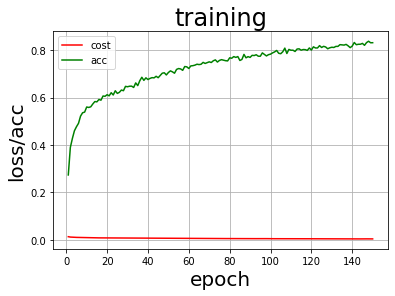

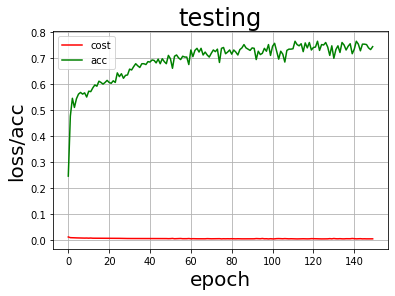

In [18]:
train(resnet18)

In [ ]:
test(resnet18)